In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import pickle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')


Success


## Reading in files

In [18]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_lepton_signal":False, 
          "Load_pi0_signal":True, 
          "Use_logit":True} 

loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"
end_str = "_full_Finished"

samples, HNL_masses = Functions.create_sig_detsys_samples_list(Params)

There are no run1 pi0 detector variation samples
Loading these run1 samples: 

[]


In [19]:
sample_test_dict = {}
for sample in samples:
    if Params["Load_lepton_signal"] == True:
        loc=loc_pkls+f"Signal_DetVars/Preselected_{sample}_"+Params["Run"]+f"_flattened_reduced_evs{end_str}.pkl"
    if Params["Load_pi0_signal"] == True:
        loc=loc_pkls+f"Signal_DetVars/pi0/Preselected_{sample}_"+Params["Run"]+f"_flattened_reduced_evs{end_str}.pkl"
    sample_test_dict[sample] = pd.read_pickle(loc)

BDT_name = "_full_Finished_10"
# if Params["Load_pi0_signal"] == True: BDT_name = "pi0_FINAL_2"

if Params["Load_pi0_signal"] == False:
    with open(f"bdts/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)
elif Params["Load_pi0_signal"] == True:
    with open(f"bdts/pi0_selection/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)
        
bdt_vars = saved_variables
print(bdt_vars)

['n_pfps', 'n_tracks', 'shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'shrclusdir2', 'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_tot', 'trk_score_v', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'NeutrinoEnergy2', 'shr_tkfit_dedx_max', 'topological_score']


In [20]:
xgb_test_dict = {}
for sample in samples:
    xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])

# for HNL_mass in Constants.HNL_mass_samples:
if Params["Load_lepton_signal"] == True:
    for HNL_mass in HNL_masses:
        # bdt = xgboost.Booster() #OLD way of loading BDT models.
        # bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_ee{BDT_name}.json") #OLD way of loading BDT models.
        filename = "bdts/"+Params["Run"]+f"_{HNL_mass}_ee{BDT_name}.pkl"
        bdt = pickle.load(open(filename, "rb"))
        
        for sample in xgb_test_dict:
            if sample.startswith(str(HNL_mass)+"_"):
                # print(sample)
                results = bdt.predict(xgb_test_dict[sample])
                sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
                
if Params["Load_pi0_signal"] == True:
    for HNL_mass in HNL_masses:
        # bdt = xgboost.Booster() #OLD way of loading BDT models.
        # bdt.load_model("bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_pi0{BDT_name}.json") #OLD way of loading BDT models.
        filename = "bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_pi0{BDT_name}.pkl"
        bdt = pickle.load(open(filename, "rb"))
        for sample in xgb_test_dict:
            if sample.startswith(str(HNL_mass)+"_"):
                # print(sample)
                results = bdt.predict(xgb_test_dict[sample])
                sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            

In [21]:
def safe_div(x,y):
    if y == 0.0:
        return 0
    return x / y

def Calc_RMS_quadsum(CV_hist, dict_detvar_hists): #Currently assuming "mean" value to be the CV, I believe this is the correct thing to do
    nbins = len(CV_hist)
    RMS_on_bins = np.zeros(nbins)
    Quad_sum_on_bins = np.zeros(nbins)
    RMS_on_bins_frac = np.zeros(nbins)
    Quad_sum_on_bins_frac = np.zeros(nbins)
    num_samples = len(dict_detvar_hists) #This should NOT include the CV hist
    for j in range(nbins): #Looping over bins
        sum_diffs_squared = 0
        for detvar in dict_detvar_hists:
            diff = dict_detvar_hists[detvar][j]-CV_hist[j] #Difference between the number in the CV sample and the DetVar sample
            sum_diffs_squared += diff**2
        variance = sum_diffs_squared/num_samples
        RMS_on_bins[j] = np.sqrt(variance) #The total RMS error on the bin
        Quad_sum_on_bins[j] = np.sqrt(sum_diffs_squared)
        RMS_on_bins_frac[j] = safe_div(np.sqrt(variance),CV_hist[j]) #Need to calculate here to avoid problems with zero divisor
        Quad_sum_on_bins_frac[j] = safe_div(np.sqrt(sum_diffs_squared),CV_hist[j])
              
    return {"RMS":RMS_on_bins, "quadsum":Quad_sum_on_bins, "RMS_frac":RMS_on_bins_frac, "quadsum_frac":Quad_sum_on_bins_frac}

def Calc_frac_diff(CV_hist, dict_detvar_hists):
    nbins = len(CV_hist)
    frac_diff_dict = {}
    perc_diff_dict = {}
    for detvar in dict_detvar_hists: #Should NOT contain CV hist
        frac_diff_on_bins = np.zeros(nbins)
        perc_diff_on_bins = np.zeros(nbins)
        for j in range(nbins): #Looping over bins
            frac = safe_div(dict_detvar_hists[detvar][j],CV_hist[j])
            frac_diff = frac - 1.0
            perc_diff = (frac_diff*100)
            frac_diff_on_bins[j] = frac_diff
            perc_diff_on_bins[j] = perc_diff
        frac_diff_dict[detvar] = frac_diff_on_bins
        perc_diff_dict[detvar] = perc_diff_on_bins
           
    return frac_diff_dict, perc_diff_dict

def Calc_stat_err(CV_hist, CV_hist_unweighted): #Calculate the statistical (Poisson) error on each bin for the central value histogram
    nbins = len(CV_hist)
    stat_err_on_bins = np.zeros(nbins)
    for j in range(nbins): #Looping over bins
        poisson_err = np.sqrt(CV_hist_unweighted[j])
        SF = CV_hist_unweighted[j]/CV_hist[j] #The factor this bin is scaled by due to weighting
        stat_err_on_bins[j] = poisson_err*SF #Need to scale the Poisson error by whatever the total scaling on the bin is
    return stat_err_on_bins

In [40]:
name_type = Functions.Get_signal_name_type(Params)
filename = name_type+BDT_name+'.root'
bins_dict = {}
bin_cents = {}
sample_names = []

if Params["Load_lepton_signal"] == True: 
    saved_loc = f'bdt_output/'
    Full_masses = Constants.HNL_mass_samples
    for mass in HNL_masses:
        sample_names.append(str(mass)+"_ee")
    
if Params["Load_pi0_signal"] == True: 
    saved_loc = f'bdt_output/pi0/'
    Full_masses = Constants.HNL_mass_pi0_samples
    for mass in HNL_masses:
        sample_names.append(str(mass)+"_pi0")

for HNL_mass in Full_masses:
    # hist_placeholder = uproot.open(saved_loc+Params["Run"]+f'_{HNL_mass}MeV_'+filename)
    hist_placeholder = uproot.open(saved_loc+Params["Run"]+f'_{HNL_mass}_'+filename)
    bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
    
    bin_cents[HNL_mass] = (np.array(bins_dict[HNL_mass][:-1])+np.array(bins_dict[HNL_mass][1:]))/2
print("Loaded bins for " + str(bins_dict.keys()))

# xlims = [bins_dict[HNL_mass][0],bins_dict[HNL_mass][-1]+4]
# xticks = np.arange(bins_dict[HNL_mass][0],bins_dict[HNL_mass][-1]+1)

print(bins_dict)
print(bin_cents)


Loaded bins for dict_keys([150, 180, 200, 220, 240, 245])
{150: array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   7.]), 180: array([-11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
         0.,   1.,   2.,   3.,   4.,   7.]), 200: array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   7.]), 220: array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   7.]), 240: array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   7.]), 245: array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   7.])}
{150: array([-9.5, -8.5, -7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,
        1.5,  2.5,  3.5,  5.5]), 180: array([-10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,
        -1.5,  -0.5,   0.5,   1.5,   2.5,   3.

## Plotting Detector Variations histograms

In [41]:
def make_overflow_bin(bins_dict, bins_cents_dict):
    """
    For making the final "overflow" bin the same size as the previous bins, i.e one integer in width.
    """
    bins_overflow, bins_cent_overflow = {}, {}
    for HNL_mass in bins_dict:
        overflow_bin = bins_cents_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin centre val. 
        bins_cent_overflow[HNL_mass] = bins_cents_dict[HNL_mass].copy()
        bins_cent_overflow[HNL_mass][-1] = overflow_bin
        bins_overflow[HNL_mass] = bins_dict[HNL_mass].copy()
        bins_overflow[HNL_mass][-1] = bins_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin end val. 
    return bins_overflow, bins_cent_overflow

bins_overflow, bins_cents_overflow = make_overflow_bin(bins_dict, bin_cents)

def make_xlims_dict(bins_dict, spacing, lower = None):
    """
    Making a dict of xlims for plotting several mass points at once.
    Also returns a dict of xticks for the purpose of indicating the overflow.
    """
    xlims_adjusted, xticks_adjusted = {}, {}
    vals_dict={}
    for HNL_mass in bins_dict:
        if isinstance(lower,(int, float)): lower_val = lower
        else: lower_val = bins_dict[HNL_mass][0]
        xlims_adjusted[HNL_mass] = [lower_val,bins_dict[HNL_mass][-1]]
        ticks = np.arange(bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1], spacing)
        if ticks[-1] != bins_dict[HNL_mass][-2]: ticks = np.append(ticks, bins_dict[HNL_mass][-1]-1)
        ticks_strings = []
        vals = []
        for val in ticks:
            ticks_strings.append(str(int(val)))
            vals.append(val)
        ticks_strings[-1] = str(ticks_strings[-1])+"+"
        xticks_adjusted[HNL_mass] = ticks_strings
        vals_dict[HNL_mass] = vals
        
    return xlims_adjusted, xticks_adjusted, vals_dict

xlims_dict, xticks_dict, vals_dict = make_xlims_dict(bins_overflow, 2)



In [9]:
# HNL_mass = 150
# if Params["Load_lepton_signal"] == True: sample_test_dict[f"{HNL_mass}_ee_CV"].keys()
# if Params["Load_pi0_signal"] == True: sample_test_dict[f"{HNL_mass}_pi0_CV"].keys()

In [10]:
def Plot_all_detvar_diffs(sample_dict, bins_original, bins_cent_dict, bins_dict, 
                          xlims_dict, xticks_dict,xticks_vals, xlim_start=-5, y_lim=50, bin_padding=4, hlines=[]):
    """
    Plot all detector variations differences from the CV sample.
    """
    DetVar_percentages_dict = {}
    quadsum_var_dict = {}
    
    plt.rcParams.update({'font.size': 28})

    figsize=(14, 6)
    linewidth = 1
    # h_lines = [15] #Line displaying this % difference

    quadsum_dict = {}

    num_bins_signal_region = 3 #Number of last bins classified as the "signal region"
    
    savefig = input("Do you want to save the plots? y/n ")

    # for HNL_mass in HNL_masses: #Looping over all mass points
    for sample_name in sample_names: #Looping over all mass points
        HNL_mass = int(sample_name.split("_")[0])
        print(f"Plotting {sample_name} histogram") 

        bins = bins_original[HNL_mass]
        nbins = len(bins)-1
        xrange = [bins_original[HNL_mass][0], bins_original[HNL_mass][-1]]
        # xlims = [bins_dict[HNL_mass][0],bins_dict[HNL_mass][-1]+5]
        xlims = [xlim_start,xlims_dict[HNL_mass][-1]+bin_padding]
        xticks = xticks_dict[HNL_mass]

        plt.figure(figsize=figsize,facecolor='white')
        RMS=np.zeros(nbins)
        frac_RMS=np.zeros(nbins)
        quad_sum=np.zeros(nbins)
        frac_quad_sum=np.zeros(nbins)
        sum_squares = np.zeros(nbins)
        stat_err = np.zeros(nbins)
        SF_on_bin = np.zeros(nbins)
        upvals = np.zeros(nbins+1)
        lowvals = np.zeros(nbins+1)
        upvals_frac = np.zeros(nbins+1)
        lowvals_frac = np.zeros(nbins+1)
        x_coords = bins_dict[HNL_mass]
        max_y = 0

        cv_hist, cv_bins = np.histogram(Functions.logit(sample_test_dict[f"{sample_name}_CV"][f'BDT_output_{HNL_mass}MeV']),
                                        range=xrange, bins=bins)
        
        # bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
        bins_cent = bins_cent_dict[HNL_mass]
        # for DetVar in Constants.Detector_variations:
        frac_diff_dict = {}
        for sample in xgb_test_dict:
            if sample.startswith(str(HNL_mass)+"_"):
                DetVar = sample.split("_")[-1]
                if sample.endswith("CV"):
                    continue
                perc_list = []

                detvar_hist, bins = np.histogram(Functions.logit(sample_test_dict[sample][f'BDT_output_{HNL_mass}MeV']),
                                                 range=xrange, bins=bins)
                for i in range(len(detvar_hist)):
                    frac = safe_div(detvar_hist[i],cv_hist[i])
                    frac_diff = frac - 1.0
                    perc_list.append(frac_diff*100)

                DetVar_percentages_dict[sample] = perc_list
                plt.hist(bins_cent,weights=DetVar_percentages_dict[sample], bins=bins_dict[HNL_mass],
                         label=f'{DetVar}',lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)

                frac_diff_dict[DetVar] = 1-(cv_hist[-num_bins_signal_region:].sum()/detvar_hist[-num_bins_signal_region:].sum()) #fraction in signal region

        cv_no_weighting = np.histogram(Functions.logit(sample_test_dict[f"{sample_name}_CV"][f'BDT_output_{HNL_mass}MeV']),
                                       bins=bins)[0]

        quadsum_var_dict[HNL_mass] = frac_diff_dict

        for j in range(len(cv_hist)):
            for sample in xgb_test_dict:
                if (sample.startswith(str(HNL_mass)+"_")) == False:
                    continue
                if sample.endswith("CV"):
                    continue

                hist_input = Functions.logit(sample_test_dict[sample][f'BDT_output_{HNL_mass}MeV'])

                detvar_hist, bins = np.histogram(hist_input, 
                                                 bins=bins)

                diff = cv_hist[j] - detvar_hist[j]
                diff_squared = diff**2
                sum_squares[j] = sum_squares[j]+diff_squared

                # SF_on_bin[j] = cv_hist[j]/cv_no_weighting[j] #This effective scale factor comes in by weighting on events
                SF_on_bin[j] = safe_div(cv_hist[j],cv_no_weighting[j])
                stat_err[j] = np.sqrt(cv_no_weighting[j])
                upvals[j] = cv_hist[j]+stat_err[j]
                lowvals[j] = cv_hist[j]-stat_err[j]
                upvals_frac[j] = safe_div(upvals[j],cv_hist[j])*100-100
                lowvals_frac[j] = safe_div(lowvals[j],cv_hist[j])*100-100

            RMS[j] = np.sqrt(sum_squares[j]/(len(Constants.Detector_variations)-1))
            frac_RMS[j] = safe_div(RMS[j],cv_hist[j])
            quad_sum[j] = np.sqrt(sum_squares[j])
            frac_quad_sum[j] = safe_div(quad_sum[j],cv_hist[j])#quad_sum[j]/cv_hist[j]
        quadsum_dict[HNL_mass] = frac_quad_sum
        max_y = max(frac_quad_sum)
        # ylims = [max_y*(-1.2)*100, max_y*(1.2)*100]
        ylims = [-1*y_lim, y_lim]
        plt.hist(bins_cent, weights=frac_quad_sum*100, bins=bins_dict[HNL_mass],label=f'Quadrature sum',lw=linewidth+2,
                 histtype="step", color="black")
        plt.hist(bins_cent, weights=frac_quad_sum*(-100), bins=bins_dict[HNL_mass],lw=linewidth+2,
                 histtype="step", color="black")

        plt.fill_between(x_coords, lowvals_frac, upvals_frac, step="post",color="grey",alpha=0.3,zorder=2)

        plt.legend(loc='center right',frameon=True, framealpha=1.0, fontsize=18)
        plt.ylim(ylims)
        print(xlims)
        plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{HNL_mass} MeV)', fontsize=30)
        plt.ylabel('% Difference', fontsize=30)

        for h_line in hlines:
            if max_y*100 > h_line:
                plt.axhline(y=h_line, lw=2, color='green', linestyle = 'dashed')
                plt.axhline(y=-1*(h_line), lw=2, color='green', linestyle = 'dashed')
                ypos_factor = y_lim/10
                plt.text(4, h_line+ypos_factor, f"{h_line}%", color='green')

        plt.xticks(ticks=xticks_vals[HNL_mass], labels=xticks)
        
        plt.xlim(xlims)

        plt.tight_layout()
        
        if savefig == "y":
            if Params["Load_lepton_signal"] == True:
                save_loc = "plots/Sys_uncertainty/Signal/DetVar/Signal_DetVars_quadsum_"
                end_name = "MeV"
            if Params["Load_pi0_signal"] == True: 
                save_loc = "plots/Sys_uncertainty/Signal/DetVar/pi0/Signal_DetVars_quadsum_"
                end_name = "MeV_pi0"
            plt.savefig(save_loc + Params["Run"] + "_" + str(HNL_mass) + end_name + ".pdf")
            plt.savefig(save_loc + Params["Run"] + "_" + str(HNL_mass) + end_name + ".png")
        # if display == False:
        #         plt.close()
    return quadsum_dict
                

Do you want to save the plots? y/n  y


Plotting 150_pi0 histogram
[-5, 11.0]
Plotting 180_pi0 histogram
[-5, 11.0]
Plotting 220_pi0 histogram
[-5, 10.0]
Plotting 240_pi0 histogram
[-5, 10.0]
Plotting 245_pi0 histogram
[-5, 10.0]


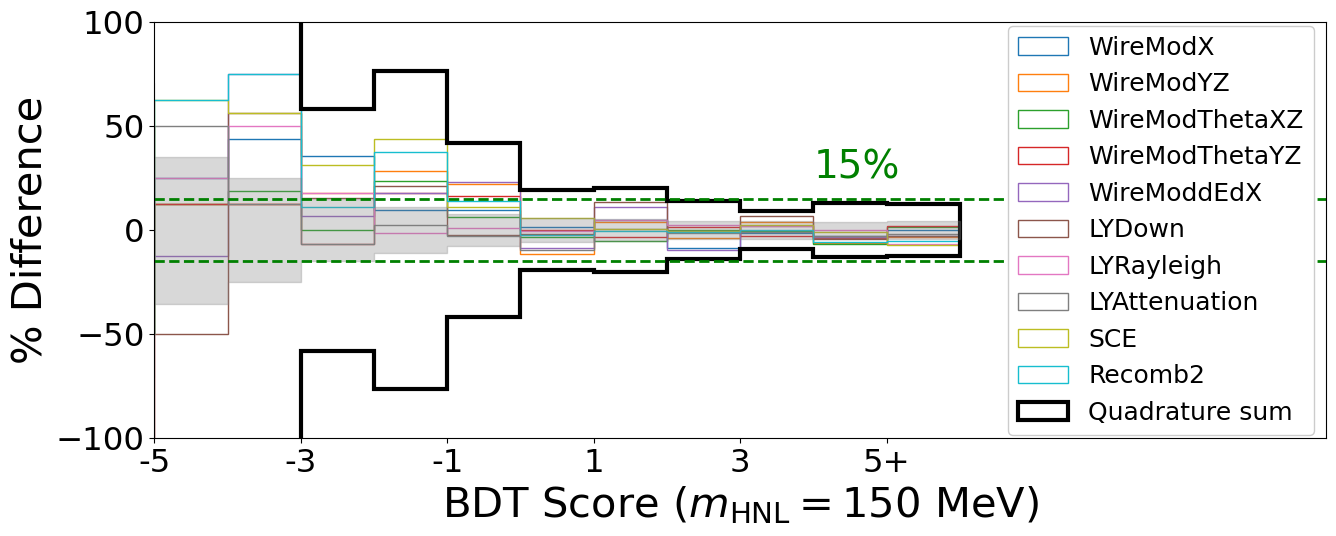

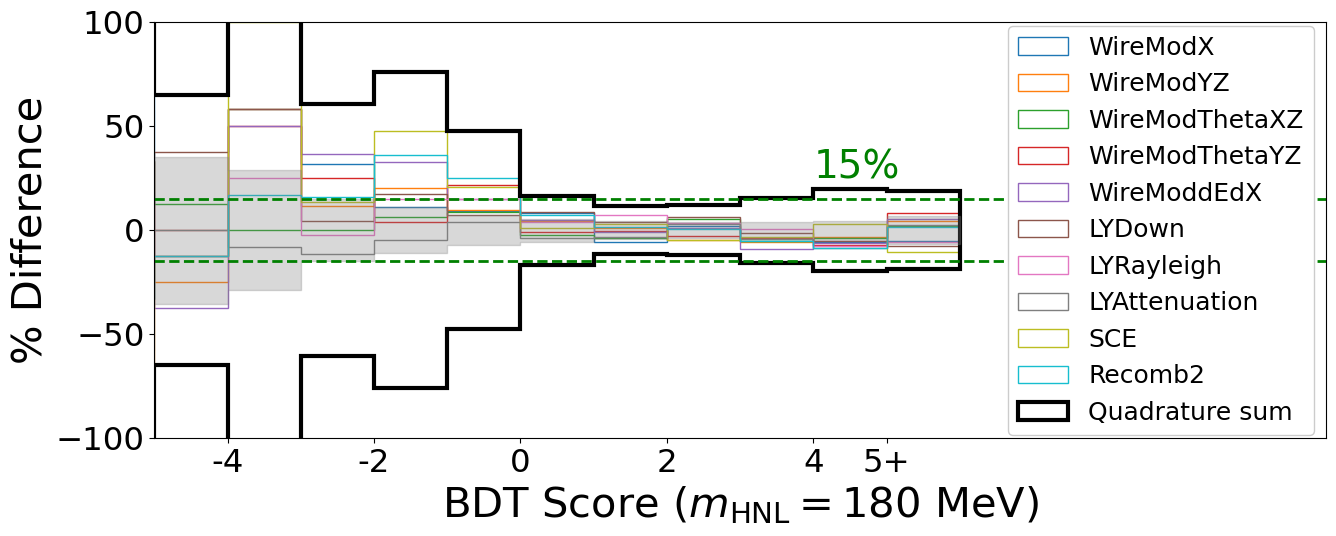

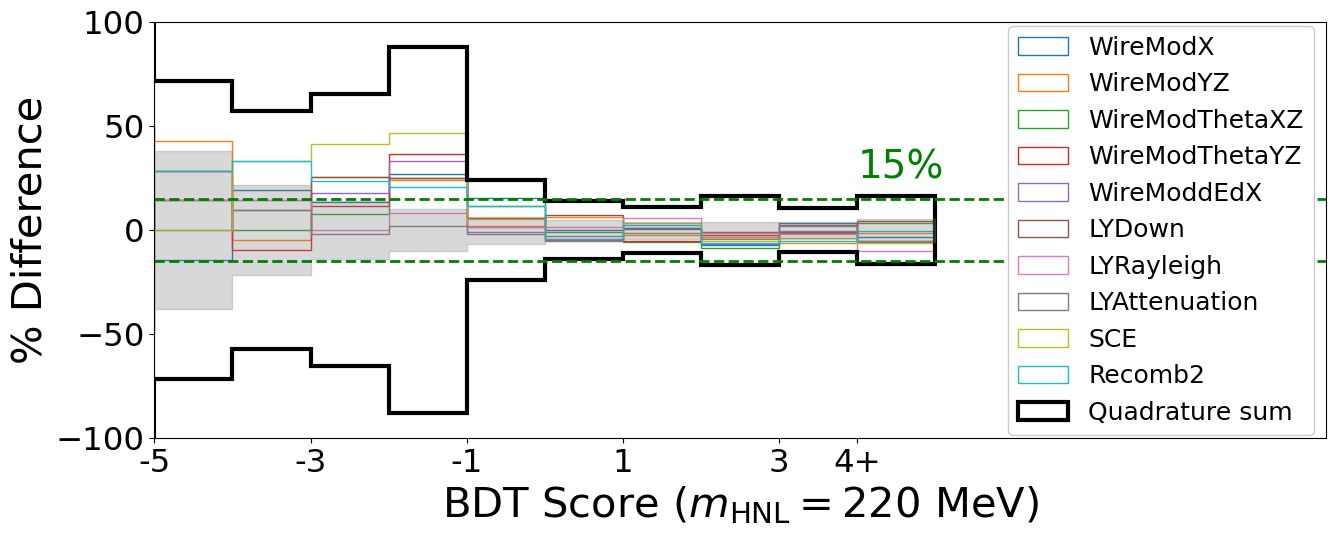

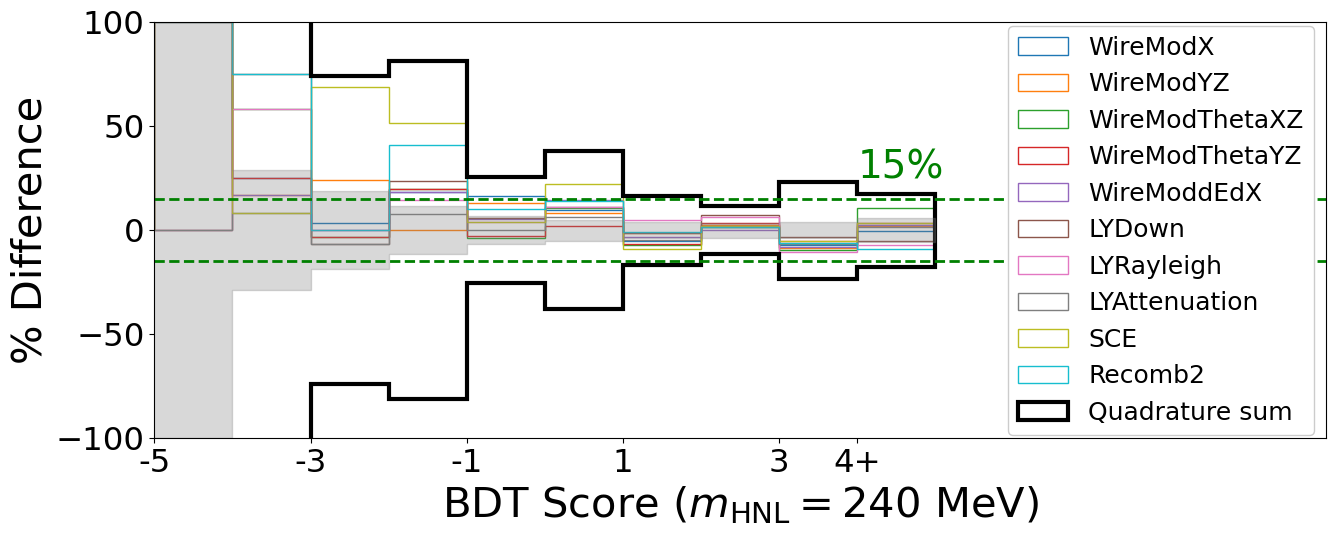

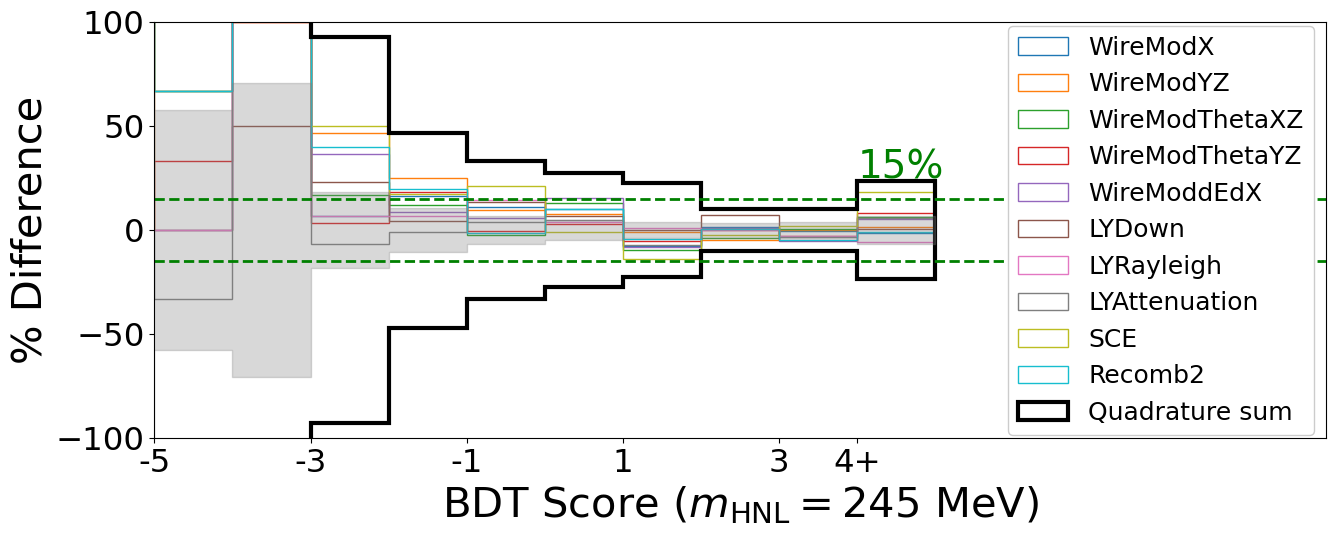

In [12]:
quadsum_dict = Plot_all_detvar_diffs(sample_test_dict, bins_dict, bins_cents_overflow, bins_overflow, 
                      xlims_dict, xticks_dict,vals_dict, xlim_start=-5,y_lim=100, bin_padding=5, hlines=[15])

## Cap quadsum uncertainty

In [42]:
#Capping the DetVar uncertainty fraction on each bin.
flat_signal_detvar = 0.15
cap = flat_signal_detvar
capped_quadsum = {}

for HNL_mass in quadsum_dict:
    nbins = len(quadsum_dict[HNL_mass])
    capped_hist = np.zeros(nbins)
    for j, frac in enumerate(quadsum_dict[HNL_mass]):
        if frac > cap: capped_hist[j] = cap
        elif frac == 0.0: capped_hist[j] = cap
        else: capped_hist[j] = frac
    capped_quadsum[HNL_mass] = capped_hist
    

In [43]:
# print(len(bins_dict[100]))
# print(len(capped_quadsum[100]))
# print(capped_quadsum)

In [44]:
print(Full_masses)
print(filename)

[150, 180, 200, 220, 240, 245]
pi0_full_Finished_10.root


In [45]:
flat_signal_detvar = 0.15 #The fraction of signal detector variation error
signal_detvar_dict, signal_detvar_frac_dict = {}, {}

loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True: loc_hists=loc_hists+"pi0/"

if Params["Load_lepton_signal"]==True: Full_masses = Constants.HNL_mass_samples
if Params["Load_pi0_signal"]==True: Full_masses = Constants.HNL_mass_pi0_samples
    
#I run through the actual overlay DetVar quadrature sum and cap at 50%, will set as constant if detvar samples aren't available
for HNL_mass in Full_masses:
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file:
        signal_vals_placeholder=file['signal'].values()
    if HNL_mass in HNL_masses: #DetVar samples available
        signal_detvar_dict[HNL_mass] = np.multiply(signal_vals_placeholder,capped_quadsum[HNL_mass])
        signal_detvar_frac_dict[HNL_mass] = np.ones_like(signal_vals_placeholder)*capped_quadsum[HNL_mass]
    else: #No DetVar samples available
        signal_detvar_dict[HNL_mass] = signal_vals_placeholder*flat_signal_detvar
        signal_detvar_frac_dict[HNL_mass] = np.ones_like(signal_vals_placeholder)*flat_signal_detvar

print("Made all uncertainties")


15
vals: 15
16
vals: 16
15
vals: 15
15
vals: 15
15
vals: 15
15
vals: 15
Made all uncertainties


## Saving uncertainties in .root files

In [48]:
loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True: loc_hists=loc_hists+"pi0/"

for HNL_mass in signal_detvar_dict:
    bins_cent=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2

    values_dict = {'signal_DetVar_uncertainty':signal_detvar_dict[HNL_mass],
                   'signal_DetVar_uncertainty_frac':signal_detvar_frac_dict[HNL_mass]} 
    hist_samples = {}

    #make array with all values 1, then weight by value
    for name in values_dict:
        test_hist = np.histogram(bins_cent, weights=values_dict[name], bins=bins_dict[HNL_mass], 
                                 range=[bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
        hist_samples[name] = test_hist

    stop_writing = False
    dont_save = []
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file: #Check what is already in the file (read-only)
        for name in hist_samples:
            if str(name)+";1" in file.keys():
                dont_save.append(name)

    with uproot.update(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file: #Add new hists into the file
        for name in hist_samples:
            if name in dont_save:
                print(f"Not saving {name}")
            else:
                file[name] = hist_samples[name]
                
print("Done")

Done


## Make quadrature sum of signal-region bins

In [ ]:
devar_list=list(quadsum_var_dict[HNL_mass].keys())

In [ ]:
print(quadsum_var_dict[HNL_mass])

In [ ]:
quadsum_var_dict.keys()
quadsum_detvar_wise = {}
quadsum_detvar_list = []
# quadsum_var_dict[2]
for DetVar in devar_list:
    quadsum_detvar_list = []
    for HNL_mass in HNL_masses:
        quadsum_detvar_list.append(quadsum_var_dict[HNL_mass][DetVar])
    quadsum_detvar_wise[DetVar] = quadsum_detvar_list
    
hnl_masses = HNL_masses
num_points = len(quadsum_var_dict.keys())
new_x_axis = np.arange(0,num_points,1)

print(num_points)
print(new_x_axis)
print(quadsum_var_dict.keys())

In [ ]:
plt.figure(figsize=[15,10])

save_fig = True

for j, HNL_mass in enumerate(quadsum_var_dict.keys()):
    quad_sum=0
    
    for i,var in enumerate(quadsum_var_dict[HNL_mass].keys()):
        color = plt.cm.tab10(i)
        label=var
        # plt.bar(hnl_masses,0,bottom=quadsum_detvar_wise[var],label=label,fill=False,edgecolor=color,lw=4, tick_label=hnl_masses)
        if j==0:
            plt.bar(new_x_axis,0,bottom=quadsum_detvar_wise[var],label=label,fill=False,edgecolor=color,lw=4, tick_label=hnl_masses)
        else:
            plt.bar(new_x_axis,0,bottom=quadsum_detvar_wise[var],fill=False,edgecolor=color,lw=4, tick_label=hnl_masses)

        quad_sum=quad_sum+np.array(quadsum_var_dict[HNL_mass][var])**2
    if j==0:
        plt.bar(j,0,bottom=np.sqrt(quad_sum),fill=False,color="black",label="Quadrature Envelope",lw=5) 
    else:
        plt.bar(j,0,bottom=np.sqrt(quad_sum),fill=False,color="black",lw=5) 
    plt.bar(j,0,bottom=-np.sqrt(quad_sum),fill=False,color="black",lw=5) 
# plt.bar(quadsum_var_dict.keys(),0,bottom=np.sqrt(quad_sum),fill=False,color="black",label="Quadrature Envelope",lw=4, tick_label=hnl_masses)  
# plt.bar(quadsum_var_dict.keys(),0,bottom=-np.sqrt(quad_sum),fill=False,color="black",lw=4, tick_label=hnl_masses)   
# plt.plot(hps_samples,detvar_frac["quad"],ls="",marker='_',markersize=30,color="black",label="Quadrature Envelope")
# plt.plot(hps_samples,-np.array(detvar_frac["quad"]),ls="",marker='_',markersize=30,color="black")

plt.axhline(0,ls="--", color="black")
plt.ylabel("Fractional Change")
plt.xlabel("HNL mass sample [MeV]")
plt.axhline(0.2,ls="--")
plt.axhline(-0.2,ls="--")
plt.legend(ncol=3,frameon=False, loc="upper center")
plt.ylim(-0.35,0.35)
plt.xlim(-1,len(new_x_axis))


if save_fig == True:
    if Params["Load_lepton_signal"] == True:
        save_loc = "plots/Sys_uncertainty/Signal/DetVar/All_Signal_DetVars_quadsum_"
    if Params["Load_pi0_signal"] == True: 
        save_loc = "plots/Sys_uncertainty/Signal/DetVar/pi0/All_Signal_DetVars_quadsum_"
    plt.savefig(save_loc + Params["Run"] + ".pdf")
    plt.savefig(save_loc + Params["Run"] + ".png")
    
plt.show()

In [ ]:
HNL_mass = 180
if Params["Use_logit"] == False:
    max_y, bin_edges = np.histogram(sample_test_dict[f"{HNL_mass}_CV"][f'BDT_output_{HNL_mass}MeV'],# weights=sample_test_dict[f"{HNL_mass}_CV"]["weight"], 
                                    bins=Params["nbins"],range=[0,1.0])
if Params["Use_logit"] == True:
    max_y, bin_edges = np.histogram(Functions.logit(sample_test_dict[f"{HNL_mass}_CV"][f'BDT_output_{HNL_mass}MeV']), 
                                    #weights=sample_test_dict[f"{HNL_mass}_CV"]["weight"], 
                                    bins=Params["nbins"],range=[-5.0,5.0])
maxium = max(max_y)
max_x = max(bin_edges)
min_x = min(bin_edges)
print(maxium)
print(max_x)
print(min_x)
print("Max minus min is " + str(max_x - min_x))
#plt.ylim(0, maxium*1.3)

In [ ]:
#Plotting the histograms for detector variations
figsize=(14, 6)
savefig = False
# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in [2, 10, 20, 50, 100, 180, 200, 220, 240, 245]: #When only have 150MeV sample
# HNL_mass = 200 # - Plot just one
    plt.figure(figsize=figsize,facecolor='white')
    for sample in xgb_test_dict:
        if sample.startswith(str(HNL_mass)+"_"):
            linewidth = 1
            if sample.endswith("_CV"):
                linewidth = 3
            if Params["Use_logit"] == False:
                plt.hist(sample_test_dict[sample][f'BDT_output_{HNL_mass}MeV'], #weights=sample_test_dict[sample]["weight"], 
                         bins=Params["nbins"],range=[0,1.0],label=f'{sample}',lw=linewidth,histtype="step")
            if Params["Use_logit"] == True:
                plt.hist(Functions.logit(sample_test_dict[sample][f'BDT_output_{HNL_mass}MeV']), #weights=sample_test_dict[sample]["weight"], 
                         bins=5,range=[0.0,5.0],label=f'{sample}',lw=linewidth,histtype="step")
            
    plt.xlabel(f'BDT_output_{HNL_mass}MeV')
    plt.legend(loc='upper left')
    #plt.yscale("log")
    plt.yscale("linear")
    # plt.ylim(1, maxium*1.3)
    if savefig == True:
        plt.savefig("plots/Sys_uncertainty/Signal/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_BDT_score_"+Params["logit_str"]+".png")

In [ ]:
DetVar_percentages_dict = {}

savefig = False

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in [2, 10, 20, 50, 100, 180, 200, 220, 240, 245]: #When only have 150MeV sample
    plt.figure(figsize=figsize,facecolor='white')
    if Params["Use_logit"] == False:
        cv_hist, cv_bins = np.histogram(sample_test_dict[f"{HNL_mass}_CV"][f'BDT_output_{HNL_mass}MeV'],
        range=[0,1.0],
        bins=20)
        # weights=sample_test_dict["CV"]["weight"])
    if Params["Use_logit"] == True:
        cv_hist, cv_bins = np.histogram(Functions.logit(sample_test_dict[f"{HNL_mass}_CV"][f'BDT_output_{HNL_mass}MeV']),
        range=[0,5.0],
        bins=5)
        # weights=sample_test_dict["CV"]["weight"])
    bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
    for DetVar in Constants.Detector_variations:
        if DetVar == "CV":
            continue
        perc_list = []
        if Params["Use_logit"] == False:
            detvar_hist, bins = np.histogram(sample_test_dict[f"{HNL_mass}_"+DetVar][f'BDT_output_{HNL_mass}MeV'],
            range=[0,1.0],
            bins=20)
            # weights=sample_test_dict[DetVar]["weight"])
        if Params["Use_logit"] == True:
            detvar_hist, bins = np.histogram(Functions.logit(sample_test_dict[f"{HNL_mass}_"+DetVar][f'BDT_output_{HNL_mass}MeV']),
            range=[0,5.0],
            bins=5)
            # weights=sample_test_dict[DetVar]["weight"])
        for i in range(len(detvar_hist)):
            frac = detvar_hist[i]/cv_hist[i]
            frac_diff = frac - 1.0
            perc_list.append(frac_diff*100)
        DetVar_percentages_dict[DetVar] = perc_list
        if Params["Use_logit"] == False:
            plt.hist(bins_cent, weights=DetVar_percentages_dict[DetVar], bins=Params["nbins"],range=[0,1.0],label=f'{DetVar}',
                lw=linewidth,histtype="step")
        if Params["Use_logit"] == True:
            plt.hist(bins_cent, weights=DetVar_percentages_dict[DetVar], bins=5,range=[0,5.0],label=f'{DetVar}',
                lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)
    plt.legend(loc='upper left',frameon=True)
    plt.ylim([-50,50])
    plt.xlabel(f'BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    #plt.yscale()
    if savefig == True:
        plt.savefig("plots/Sys_uncertainty/Signal/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_perc_difference_"+Params["logit_str"]+".png")

## Saving output to .root files

In [ ]:
def Save_one_hist(hist,name,nbins,xlims):
    tData = ROOT.TH1F(name,name,nbins,xlims[0],xlims[1])
    for i in range(nbins):
        tData.SetBinContent(i+1,hist['hist'][i])
        tData.SetBinError(i+1,hist['err'][i])
    return tData
    
def SaveToRoot_new(nbins,xlims,hist_samples,fileName='test.root'): 
    rFile = ROOT.TFile(f'bdt_output/{fileName}','RECREATE')
    for name in hist_samples:
        tData = Save_one_hist(hist_samples[name],name,nbins,xlims)
        rFile.Write()
    #rFile.Write()
    rFile.Close()

def make_stat_err(hist, SF):
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

In [ ]:
original_theta = Constants.theta_mu_4

SCALE_UP_dict = {20:200,50:50,100:10,150:5,180:5,200:2} #Doing this because the scale factor used in pyhf is bounded

new_theta_dict = {}

train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)

nbins = 20

for HNL_mass in Constants.HNL_mass_samples:
    new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict[HNL_mass]
    SCALE_EVENTS = SCALE_UP_dict[HNL_mass]**4 #The Number of events is proportional to theta^4
    
    if Params["Run"] == "run1":
        SF_signal_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
        SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run1*SF_test
        SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run1
        SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
    if Params["Run"] == "run3":
        SF_signal_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*Constants.run3_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
        SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run3*SF_test
        SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run3
        SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
    
    if Params["Use_logit"] == False:
        xlims_standard = (0.0,1.0)
        xlims = [0.0,1.0]
        signal_bdt_hist = np.histogram(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV'], 
                                   bins=nbins, weights=SF_signal_list, range = xlims_standard)
        overlay_bdt_hist = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'], 
                                    bins=nbins, weights=SF_overlay_list, range = xlims_standard)
        dirt_bdt_hist = np.histogram(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV'], 
                                 bins=nbins, weights=SF_dirt_list, range = xlims_standard)
        EXT_bdt_hist = np.histogram(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV'], 
                                bins=nbins, weights=SF_EXT_list, range = xlims_standard)
    if Params["Use_logit"] == True:
        xlims_logit = (-5.0,5.0)
        xlims = [-5.0,5.0] #This could be changed to [0,1.0] and root would just rescale the axis, could be useful to do this. 
        signal_bdt_hist = np.histogram(Functions.logit(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']), 
                                   bins=nbins, weights=SF_signal_list, range = xlims_logit)
        overlay_bdt_hist = np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']), 
                                    bins=nbins, weights=SF_overlay_list, range = xlims_logit)
        dirt_bdt_hist = np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']), 
                                 bins=nbins, weights=SF_dirt_list, range = xlims_logit)
        EXT_bdt_hist = np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']), 
                                bins=nbins, weights=SF_EXT_list, range = xlims_logit)
    
    signal_bdt_err = make_stat_err(signal_bdt_hist, Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS)
    overlay_bdt_err = make_stat_err(overlay_bdt_hist, Constants.SF_overlay_run1*SF_test)
    dirt_bdt_err = make_stat_err(dirt_bdt_hist, Constants.SF_dirt_run1)
    EXT_bdt_err = make_stat_err(EXT_bdt_hist, Constants.SF_EXT_run1)
    
    data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]
    
    bkg_overlay = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(overlay_bdt_hist[0]), 'err': np.array(overlay_bdt_err)}
    bkg_dirt = {'bins': np.array(dirt_bdt_hist[1]), 'hist': np.array(dirt_bdt_hist[0]), 'err': np.array(dirt_bdt_err)}
    bkg_EXT = {'bins': np.array(EXT_bdt_hist[1]), 'hist': np.array(EXT_bdt_hist[0]), 'err': np.array(EXT_bdt_err)}
    sig = {'bins': np.array(signal_bdt_hist[1]), 'hist': np.array(signal_bdt_hist[0]), 'err': np.array(signal_bdt_err)}
    data = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(data_h), 'err': np.array(overlay_bdt_err)}
    
    hist_samples = {"bkg_overlay":bkg_overlay,"bkg_dirt":bkg_dirt,"bkg_EXT":bkg_EXT,"signal":sig,"data":data}
    
    if Params["Use_logit"] == False:
        save_name = Params["Run"]+f"_{HNL_mass}MeV_test4.root"
    if Params["Use_logit"] == True:
        save_name = Params["Run"]+f"_{HNL_mass}MeV_logit_test4.root"
    
    SaveToRoot_new(nbins,xlims,hist_samples,fileName=save_name)

with open('bdt_output/new_theta_dict.pkl', 'wb') as handle: #Saving the scaled thetas dictionary
    pickle.dump(new_theta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# End of code